#**Importing Libraries**

In [1]:
import requests
import pandas as pd
import datetime
import time
import random
import gensim
import re
import spacy
import yfinance as yf
import numpy as np
import tensorflow as tf
import xgboost as xgb

In [2]:
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from bertopic import BERTopic

In [3]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

#**Scraping news Dataset**

In [5]:
def scrape_news(query, start_date, end_date, max_entries = 5):
    """
    Scrapes news articles from Google News RSS for a given query and filters them by data.

    Parameters:
        query(str): the stock or company name to search for.
        start_date(date): the start date for filtering articles.
        end_date(date): the end date for filtering articles.
        max_entries(int): number of times to retry incase of request failure.

    returns:
        pd.DataFrame: a dataframe consisting of article title, link, and publication date
    """
    articles = []
    url = f"https://news.google.com/rss/search?q={query}+after:{start_date}+before:{end_date}"
    for i in range(max_entries):
        try:
            response = requests.get(url)
            break
        except exception as e:
            print(f"an error occured in requesting {e}")
            print(f"retrying attempt {i}")
            time.sleep(random.uniform(2,10))

    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')

    for item in items:
        title = item.title.text
        link = item.link.text
        pub_date = item.pubDate.text
        articles.append({'title': title, 'link': link, 'pub_date': pub_date})
    return pd.DataFrame(articles)

In [6]:
def scrape_news_over_date_range(query, start_date, end_date):
    """
    Scrapes news articles over a given date range by iterating through months.

    Parameters:
        query(str): The stock or company name to search for.
        start_date(str): the start date in 'yyyy-mm-dd' format.
        end_date(str): the end date in 'yyyy-mm-dd' format.

    Returns:
        pd.DataFrame: A DataFrame collected across the date range.
    """
    start_date_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()

    all_articles = pd.DataFrame()

    current_date = start_date_dt

    while current_date<end_date_dt:
        next_date = min(current_date + relativedelta(months = 1), end_date_dt)

        start_str = current_date.strftime('%Y-%m-%d')
        end_str = next_date.strftime('%Y-%m-%d')
        month_articles = scrape_news(query, start_str, end_str)
        all_articles = pd.concat([all_articles, month_articles], ignore_index=True)
        current_date = next_date

    return all_articles

In [7]:
def scrape_and_save_news(queries, start_date, end_date):
    """
    Scrapes news articles for mutliple queries over a gives date range and saves each result to a csv file

    Parameters:
        queries(list): A list of stock or company names to search for.
        start_date(str): the start date in 'yyyy-mm-dd' format.
        end_date(str): the end date in 'yyyy-mm-dd' format.

    Outputs:
        CSV files named after each query, containing scraped news articles.
    """
    for query in queries:
        articles = scrape_news_over_date_range(query, start_date, end_date)
        output_csv = f"{query}.csv"
        articles.to_csv(output_csv, index=False)
        print(f"Saved {query} articles to {output_csv}")

In [8]:
queries = ["NVIDIA", "Microsoft", "Google"]
start_date = '2023-01-1'
end_date = '2025-05-25'
scrape_and_save_news(queries, start_date, end_date)

Saved NVIDIA articles to NVIDIA.csv
Saved Microsoft articles to Microsoft.csv
Saved Google articles to Google.csv


In [9]:
news_df1 = pd.read_csv('NVIDIA.csv')
news_df2 = pd.read_csv('Microsoft.csv')
news_df3 = pd.read_csv('Google.csv')

#***Pre-Processing***

In [10]:
def clean_text(text: str):
    """
    Cleans the text and returns in form of tokens.

    Parameters:
    text(str): string to be cleaned.

    Returns:
    str: a joint of tokens created.
    """
    text = text.lower()
    doc = nlp(text.lower())

    tokens = [token.lemma_ for token in doc
             if not token.is_stop
             and not token.is_punct
             and token.text not in ["'", '"']]

    return ' '.join(tokens)

In [11]:
news_df1['cleaned_text'] = news_df1['title'].apply(clean_text)
news_df2['cleaned_text'] = news_df2['title'].apply(clean_text)
news_df3['cleaned_text'] = news_df3['title'].apply(clean_text)

#**Extracting Stock Prices for supervised training**

In [12]:
start_date = '2025-01-01'
end_date = '2025-12-31'

stock_symbols = {'NVIDIA': 'NVDA', 'Microsoft': 'MSFT', 'Google': 'GOOGL'}

date_range = pd.date_range(start = start_date, end = end_date, freq = 'B') # 'B' for business days

def fetch_stock_data(symbol: str, max_entries=3):
    """
    Fetches stock data from Yahoo Finance.

    Parameters:
        symbol (str): The stock ticker symbol.
        max_entries (int): Number of retry attempts if fetching fails.

    Returns:
        pd.DataFrame: Dataset containing stock prices or empty DataFrame on failure.
    """
    for i in range(max_entries):
        try:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            if not stock_data.empty:
                return stock_data
        except Exception as e:
            print(f"Error fetching data: {e}; retrying attempt {i + 1}...")
            time.sleep(random.uniform(2, 5))

    print(f"Failed to fetch data for {symbol} after {max_entries} attempts.")
    return pd.DataFrame()  # return empty DataFrame if all retries fail


In [13]:
for company, symbol in stock_symbols.items():
    stock_data = fetch_stock_data(symbol)
    stock_data.reset_index(inplace = True)
    output_csv = f'{company}_stock_prices.csv'
    stock_data.to_csv(output_csv, index = False)
    print(f"stock_price for {company} saved")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


stock_price for NVIDIA saved


[*********************100%***********************]  1 of 1 completed


stock_price for Microsoft saved


[*********************100%***********************]  1 of 1 completed

stock_price for Google saved


In [14]:
stock_df1 = pd.read_csv('NVIDIA_stock_prices.csv')
stock_df2 = pd.read_csv('Microsoft_stock_prices.csv')
stock_df3 = pd.read_csv('Google_stock_prices.csv')

#**Sentiment Scores**

In [15]:
news_df1['sentiment'] = news_df1['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df2['sentiment'] = news_df2['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df3['sentiment'] = news_df3['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

#**Merging the needed Dataset**

In [16]:
def merge_data(news_df:pd.DataFrame, stock_df:pd.DataFrame, company:str):
    """
    Merge the news dataframe with stock prices dataframe for every company

    Parametes:
        news_df(pd.DataFrame): dataframe containing the features.
        stock_df(pd.DataFrame): dataframe containing the the stock prices
        company(str): company to which the dataframes belong to.

    Output:
        Saves csv file of merged pdf under the name  "merged_data_{company}.csv".
    """
    news_df['pub_date'] = pd.to_datetime(news_df['pub_date']).dt.date
    stock_df['Date'] = pd.to_datetime(news_df['pub_date']).dt.date

    merged_df = pd.merge(news_df, stock_df, left_on = 'pub_date', right_on = 'Date', how = 'inner')

    output_csv = f'merged_data_{company}.csv'
    merged_df.to_csv(output_csv, index = False)
    print(f"merged data for company: {company}")

In [17]:
merge_data(news_df1, stock_df1, 'NVIDIA')
merge_data(news_df2, stock_df2, 'Microsoft')
merge_data(news_df3, stock_df3, 'Google')

merged data for company: NVIDIA
merged data for company: Microsoft
merged data for company: Google


In [18]:
df1 = pd.read_csv('merged_data_NVIDIA.csv')
df2 = pd.read_csv('merged_data_Microsoft.csv')
df3 = pd.read_csv('merged_data_Google.csv')

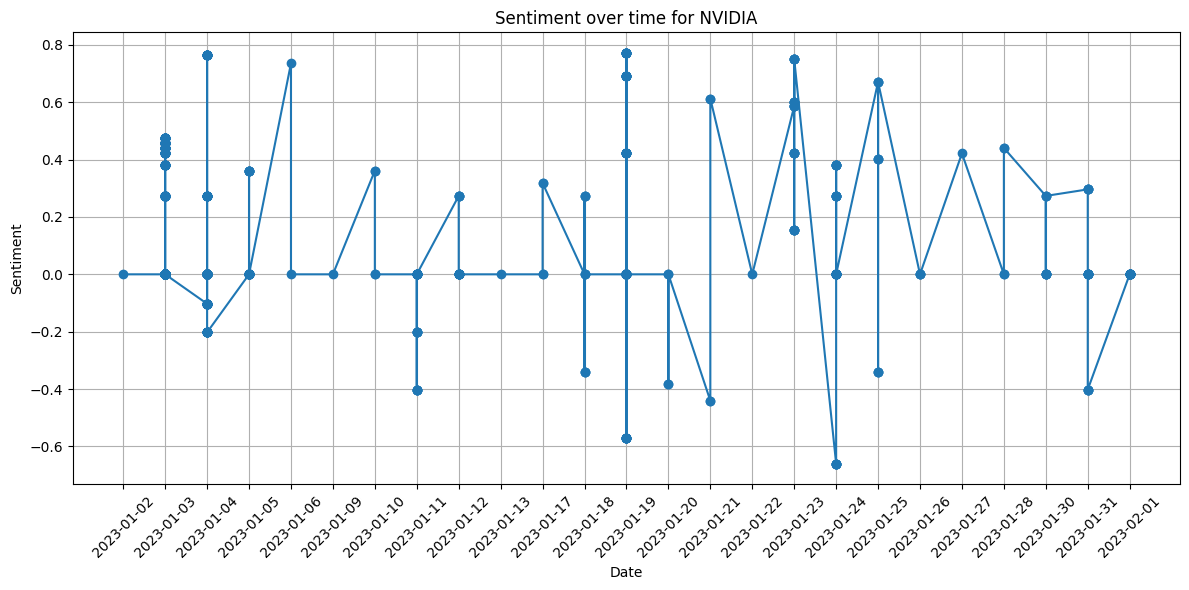

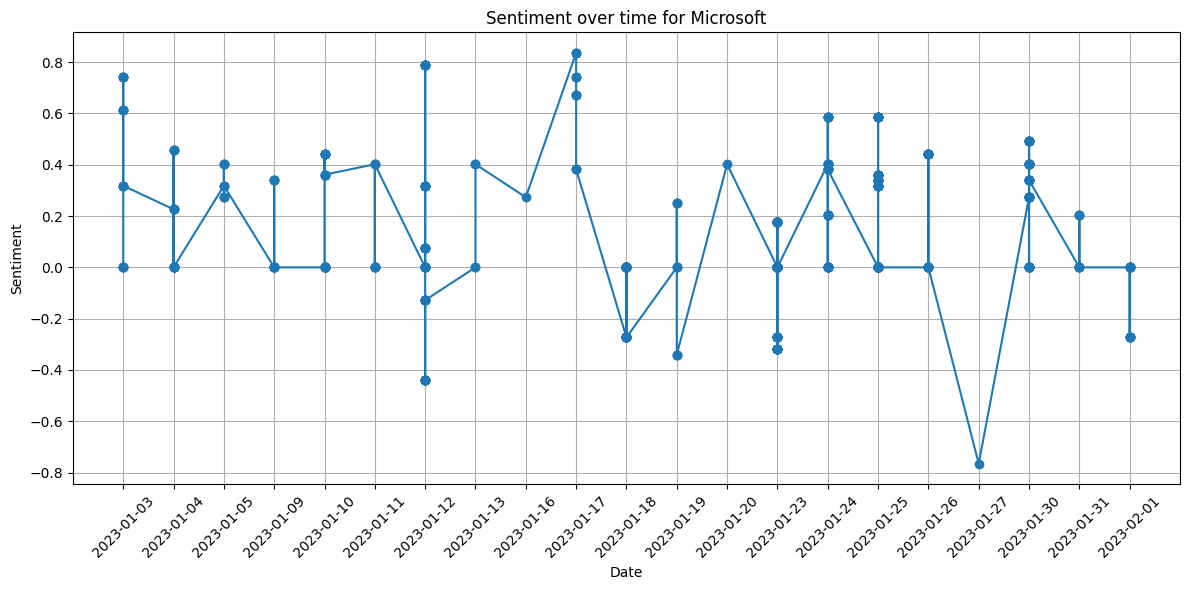

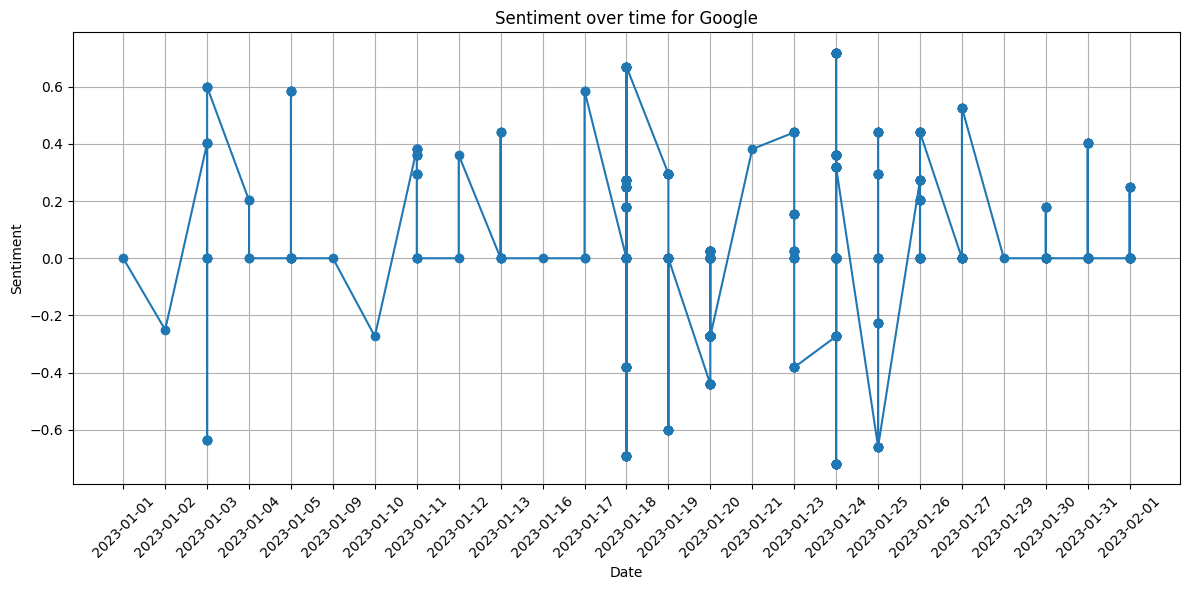

In [19]:
queries = {'NVIDIA': df1, 'Microsoft': df2, 'Google': df3}

for query, df in queries.items():
    df = df.sort_values('Date')  # ✅ Sort by date to avoid zig-zags

    plt.figure(figsize=(12, 6))  # ✅ Set figure size before plotting

    plt.plot(df['Date'], df['sentiment'], marker='o')
    plt.title(f'Sentiment over time for {query}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.xticks(rotation=45)  # ✅ Rotate x-ticks for readability
    plt.tight_layout()
    plt.grid(True)
    plt.show()


#**Getting the labels**

In [20]:
def calculate_price_movement(df: pd.DataFrame, condition: str):
    """
    Adds a new column to the DataFrame indicating stock price movement over a specified time period.

    Parameters:
        df (pd.DataFrame): A DataFrame containing merged stock and news data.
        condition (str): Specifies the time period for price change calculation.
            - 'daily': Price change over one day.
            - 'weekly': Price change over one week.
            - 'monthly': Price change over one month.

    Returns:
        pd.DataFrame: The updated DataFrame with a new column "{conditon}_movement" representing price movement.
    """

    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df = df.sort_values(by = 'Date')

    if condition =='daily':
        df['daily_movement'] =  None
        last_price = {}
        for i in range(len(df)):
            current_date= df.loc[i, 'Date']
            current_price = df.loc[i, 'Close']
            last_date = max([d for d in last_price.keys() if d<current_date], default = None)
            if last_date:
                df.loc[i, 'daily_movement'] = (
                    'increase' if current_price>last_price[last_date] else
                    'decrease' if current_price<last_price[last_date] else
                    'same'
                )
            last_price[current_date] = current_price
        return df

    elif condition == 'weekly':
        df['weekly_movement'] = None
        last_week_end = None

        for week_start in sorted(df['Date'].unique()):
            week_end = week_start+pd.Timedelta(days = 6)
            past_week_prices = df[(df['Date']>=last_week_end) & (df['Date']<week_start)]['Close']
            new_week_prices = df[(df['Date']>=week_start) & (df['Date']<=week_end)]['Close']

            if not past_week_prices.empty and not new_week_prices.empty:
                past_week_price = past_week_prices.iloc[-1]
                new_week_price = new_week_prices.iloc[-1]

                df.loc[df['Date']==week_start, 'weekly_movement'] = (
                    'increase' if new_week_price>past_week_price else
                    'decrease' if new_week_price<past_week_price else
                    'same'
                )
            last_week_end = week_end
        return df

    elif condition == 'monthly':
        df['monthly_movement'] = None
        last_month_end = None
        for month_start in sorted(df['Date'].unique()):
            month_end = month_start + relativedelta(months=1)-pd.Timedelta(days=1)
            past_month_prices = df[(df['Date']>=last_month_end) & (df['Date']< month_start)]['Close']
            new_month_prices = df[(df['Date']>=month_start) & (df['Date']<=month_end)]['Close']

            if not past_month_prices.empty and not new_month_prices.empty:
                past_month_price = past_month_prices.iloc[-1]
                new_month_price = new_month_prices.iloc[-1]

                df.loc[df['Date']==week_start, 'monthly_movement'] = (
                    'increase' if past_month_price<new_month_price else
                    'decrease' if past_month_price>new_month_price else
                    'same'
                )
            last_month_end = month_end
        return df
    else:
        raise ValueError(f"Invalid condition '{condition}'. Expected one of these: ['daily', 'weekly', 'monthly'].")
        return

In [21]:
df_1 = calculate_price_movement(df1, 'daily')
df_1.dropna(subset=['daily_movement'], inplace=True)
df_2 = calculate_price_movement(df2, 'daily')
df_2.dropna(subset=['daily_movement'], inplace=True)
df_3 = calculate_price_movement(df3, 'daily')
df_3.dropna(subset=['daily_movement'], inplace=True)

#***Feature Extraction***

##Word2Vec

In [22]:
df_1['tokenized_text'] = df_1['cleaned_text'].apply(lambda x: x.split())
df_2['tokenized_text'] = df_2['cleaned_text'].apply(lambda x: x.split())
df_3['tokenized_text'] = df_3['cleaned_text'].apply(lambda x: x.split())

In [23]:
def get_word2vec_embedding(text:list, model, vector_size = 50):
    """
    Coverts the sentences into a fixed size vector by averaging the word2vec embeddings of its words

    Parameters:
        text(list): list of tokenized words.
        model(word2vec): trained word2vec model
        vector_size(int): size of the word embedding

    Returns:
        np.array: Sentence embedding vector.
    """

    words = [word for word in text if word in model.wv]
    if not words:
        return np.zeros(vector.size)
    return np.mean([model.wv[word] for word in words], axis = 0)

In [24]:
word2vec_model1 = Word2Vec(sentences = df_1['tokenized_text'], vector_size = 100, window =5, min_count =2, workers = 4)
word2vec_model2 = Word2Vec(sentences = df_2['tokenized_text'], vector_size = 100, window =5, min_count =2, workers = 4)
word2vec_model3 = Word2Vec(sentences = df_3['tokenized_text'], vector_size = 100, window =5, min_count =2, workers = 4)

df_1['embedding'] = df_1['tokenized_text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model1))
df_2['embedding'] = df_2['tokenized_text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model2))
df_3['embedding'] = df_3['tokenized_text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model3))

#**BERTopic**

In [25]:
bertopic_model_1 = BERTopic(nr_topics = 'auto')
topics_1, _ = bertopic_model_1.fit_transform(df_1['cleaned_text'])
df_1['topic'] = topics_1
bertopic_model_2 = BERTopic(nr_topics = 'auto')
topics_2, __ = bertopic_model_2.fit_transform(df_2['cleaned_text'])
df_2['topic'] = topics_2
bertopic_model_3 = BERTopic(nr_topics = 'auto')
topics_3, ___ = bertopic_model_3.fit_transform(df_3['cleaned_text'])
df_3['topic'] = topics_3

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#**Label Encoding**

In [26]:
data = pd.concat([df_1, df_2, df_3], ignore_index = True)
label_encoder = LabelEncoder()

data['labels'] = label_encoder.fit_transform(data['daily_movement'])

#**Model Traning**

##**Test_train split**

In [27]:
X = data[['sentiment', 'embedding', 'topic']].copy()
y = data['labels']

In [28]:
word2vec_features = np.vstack(X['embedding'].values)

X.drop(columns = ['embedding'], inplace = True)
word2vec_features_names = [f'word2vec_{i}' for i in range(word2vec_features.shape[1])]
X.join(pd.DataFrame(word2vec_features, columns= word2vec_features_names))

,sentiment,topic,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,...,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99
0,0.00,0,-0.000339,0.070375,-0.032865,-0.004530,0.003337,-0.086437,0.056030,0.148946,...,0.102875,0.102887,-0.003008,0.042880,0.114145,0.079594,0.047940,-0.001089,0.052597,0.001911
1,0.00,0,-0.000339,0.070375,-0.032865,-0.004530,0.003337,-0.086437,0.056030,0.148946,...,0.102875,0.102887,-0.003008,0.042880,0.114145,0.079594,0.047940,-0.001089,0.052597,0.001911
2,0.00,0,-0.000339,0.070375,-0.032865,-0.004530,0.003337,-0.086437,0.056030,0.148946,...,0.102875,0.102887,-0.003008,0.042880,0.114145,0.079594,0.047940,-0.001089,0.052597,0.001911
3,0.00,0,-0.000339,0.070375,-0.032865,-0.004530,0.003337,-0.086437,0.056030,0.148946,...,0.102875,0.102887,-0.003008,0.042880,0.114145,0.079594,0.047940,-0.001089,0.052597,0.001911
4,0.00,0,-0.000339,0.070375,-0.032865,-0.004530,0.003337,-0.086437,0.056030,0.148946,...,0.102875,0.102887,-0.003008,0.042880,0.114145,0.079594,0.047940,-0.001089,0.052597,0.001911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,0.00,2,-0.048740,0.042221,0.032711,0.004683,-0.006121,-0.093706,0.052762,0.239494,...,0.128377,0.056425,-0.003358,0.007265,0.159801,0.065733,0.052841,-0.079042,0.016963,-0.009669
1710,0.25,13,-0.042622,0.044002,0.033446,0.002589,-0.003942,-0.083696,0.045779,0.213316,...,0.109565,0.050884,0.000332,0.005073,0.145613,0.060480,0.048225,-0.071200,0.015717,-0.005596
1711,0.25,13,-0.042622,0.044002,0.033446,0.002589,-0.003942,-0.083696,0.045779,0.213316,...,0.109565,0.050884,0.000332,0.005073,0.145613,0.060480,0.048225,-0.071200,0.015717,-0.005596
1712,0.00,7,-0.052229,0.058594,0.039428,0.004654,-0.010496,-0.115513,0.065659,0.289142,...,0.149430,0.071335,-0.002830,0.008968,0.195791,0.081409,0.067896,-0.094846,0.015540,-0.003413


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42, stratify = y)

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state =42, stratify = y)

##**XGBoost Model**

In [31]:
xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    learning_rate = 0.01,
    max_dept = 10,
    n_estimators = 200,
    colsample_bytree=0.8,
    subsample = 0.8,
    randomstate = 42
)

xgb_model.fit(X_train, y_train, verbose = 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_dept=10,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [32]:
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6151603498542274

##**Neural Network**

In [33]:
num_classes = len(y.unique())

y_train_c = to_categorical(y_train, num_classes= num_classes)
y_test_c = to_categorical(y_test, num_classes= num_classes)

X_train_seq = np.expand_dims(X_train, axis = 1)
X_test_seq = np.expand_dims(X_test, axis = 1)

#**LSTM Model**

In [34]:
def create_lstm_model(input_shape, num_classes):
    """
    creates an lstm model for stock price movement prediction

    Parameters:
        input_shape(tuple):shape of input_data(timestep, features)
        num_classes (int): number of target classes

    Returns:
        keras.Model: compiled LSTM model
    """

    model = Sequential([
        LSTM(256, return_sequences = True, input_shape = input_shape),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(128, return_sequences = True),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(64, return_sequences = True),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(32),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation = 'relu'),
        Dense(num_classes, activation = 'sigmoid')
    ])

    Optimizer = Adam(learning_rate = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = Optimizer, metrics=['accuracy'])
    return model

In [35]:
lstm_model = create_lstm_model(X_train_seq.shape[1:], num_classes)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor = 0.5, verbose = 1)
lstm_model.fit(X_train_seq, y_train_c, epochs=50, batch_size = 32, validation_data = (X_test_seq, y_test_c), callbacks=[lr_scheduler])

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.5327 - loss: 0.7684 - val_accuracy: 0.4985 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5729 - loss: 0.6970 - val_accuracy: 0.4985 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6017 - loss: 0.6855 - val_accuracy: 0.4985 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5877 - loss: 0.6856
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5873 - loss: 0.6857 - val_accuracy: 0.4985 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5798 - loss: 0.6790 - val_accuracy: 0.4985 - val_loss: 0.6953 - learning_rate: 5.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5846 - loss: 0.6762 - val

In [36]:
lstm_model.evaluate(X_test_seq, y_test_c, verbose=0)[1]

0.6239067316055298

#**GRU**

In [37]:
def create_gru_model(input_shape):
    """
    creates a GRU model for stock price movement.
    Parameters:
        input_shape(tuple):shape of input_data(timestep, features)

    Returns:
        keras.Model: compiled GRU model.
    """

    model = Sequential([
        GRU(256, return_sequences = True, input_shape = input_shape),
        BatchNormalization(),
        Dropout(0.2),

        GRU(128, return_sequences = True),
        BatchNormalization(),
        Dropout(0.2),

        GRU(64, return_sequences = True),
        BatchNormalization(),
        Dropout(0.2),

        GRU(32),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation = 'relu'),
        Dense(1, activation='sigmoid')

    ])

    optimizer = Adam(learning_rate = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
y_train_c = np.argmax(y_train_c, axis=1)
y_test_c = np.argmax(y_test_c, axis=1)

In [39]:
gru_model = create_gru_model(X_train_seq.shape[1:])
gru_model.fit(X_train_seq, y_train_c, epochs = 50, batch_size = 32, validation_data = (X_test_seq, y_test_c), callbacks = [lr_scheduler])

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5106 - loss: 0.7623 - val_accuracy: 0.4781 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5639 - loss: 0.7012 - val_accuracy: 0.5015 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5673 - loss: 0.6948 - val_accuracy: 0.5219 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/50
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5812 - loss: 0.6905
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5797 - loss: 0.6907 - val_accuracy: 0.5306 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5862 - loss: 0.6644 - val_accuracy: 0.4927 - val_loss: 0.6979 - learning_rate: 5.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5808 - loss: 0.6778 - val

In [40]:
gru_model.evaluate(X_test_seq, y_test_c, verbose=0)[1]

0.5976676344871521